In [54]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [68]:
def new_create_optimal_piecewise_linear_paths(N, M, T, dt, V, J_V_init, J_V_final, mu_V_init, mu_V_final, num_control_points):
    """Placeholder definition. """
    
    # Dense time grid for evaluation.
    times_dense = np.arange(0, T + dt, dt)
    
    # Number of control points and free (intermediate) points.
    n_points = num_control_points
    n_int = n_points - 2

    # Initial guesses for the control values (linearly spaced between endpoints).
    J_initial_guess = np.linspace(J_V_init, J_V_final, n_points)[1:-1]
    mu_initial_guess = np.linspace(mu_V_init, mu_V_final, n_points)[1:-1]
    t_initial_guess = T * np.linspace(0, 1, n_points)[1:-1]

    # Combine intermediate control values and times into one vector.
    x0 = np.concatenate((J_initial_guess, mu_initial_guess, t_initial_guess))
    
    # A small buffer to ensure strict ordering of times.
    eps = 1e-3

    # Constraints for the intermediate times: they must be strictly between 0 and T and in ascending order.
    cons = []
    cons.append({'type': 'ineq', 'fun': lambda x: x[2*n_int] - eps})
    for i in range(1, n_int):
        cons.append({
            'type': 'ineq',
            'fun': lambda x, i=i: x[2*n_int + i] - x[2*n_int + i - 1] - eps
        })
    cons.append({'type': 'ineq', 'fun': lambda x: T - x[2*n_int + n_int - 1] - eps})
    
    # Weights for the penalty terms.
    """lambda_adiabatic = 0.25       
    lambda_smooth_J = 0.1 
    lambda_smooth_mu = 0.1"""
    
    lambda_adiabatic = 0
    lambda_smooth_J = 0
    lambda_smooth_mu = 0
    
    def objective(x):
        # Unpack the optimization vector.
        J_int = x[:n_int]
        mu_int = x[n_int:2*n_int]
        t_int = x[2*n_int:3*n_int]
        
        # Reconstruct full control arrays including fixed endpoints.
        J_control = np.concatenate(([J_V_init], J_int, [J_V_final]))
        mu_control = np.concatenate(([mu_V_init], mu_int, [mu_V_final]))
        t_control = np.concatenate(([0.0], t_int, [T]))
        
        # Build dense paths using linear interpolation.
        J_path_dense = np.interp(times_dense, t_control, J_control)
        mu_path_dense = np.interp(times_dense, t_control, mu_control)
        
        # Penalty for any negative x/|V| values.
        negative_mu_penalty = np.sum(np.abs(np.minimum(0, mu_path_dense)))
        negative_J_penalty = np.sum(np.abs(np.minimum(0, J_path_dense)))
        
        """ # Smoothness penalty using discrete second differences.
        smoothness_penalty_J = lambda_smooth_J * np.sum(np.diff(J_control, 2)**2)
        smoothness_penalty_mu = lambda_smooth_mu * np.sum(np.diff(mu_control, 2)**2)
        smoothness_penalty = smoothness_penalty_J + smoothness_penalty_mu"""
        
        # Construct Hamiltonians at each point in the dense time grid.
        hamiltonians = []
        for i, t in enumerate(times_dense):
            ham = construct_rescaled_hamiltonian(N, M, V,
                                                 mu_V_ratio=mu_path_dense[i],
                                                 J_V_ratio=J_path_dense[i])
            hamiltonians.append(ham)
        
        """# Adiabaticity penalty: discourages rapid changes in the Hamiltonian.
        adiabatic_penalty = 0.0
        for i in range(len(times_dense) - 1):
            # Finite difference approximation for the derivative of the control parameters.
            dJ = J_path_dense[i+1] - J_path_dense[i]
            dmu = mu_path_dense[i+1] - mu_path_dense[i]
            dH_norm = np.sqrt(dJ**2 + dmu**2)
            # Compute the energy gap using the instantaneous Hamiltonian.
            energies, _ = exact_diagonalize(hamiltonians[i])
            gap = energies[1] - energies[0]
            adiabatic_penalty += (dH_norm**2 / gap**2) * (times_dense[i+1] - times_dense[i])
        adiabatic_penalty *= lambda_adiabatic"""
        
        # Simulate the time evolution and compute the ground state infidelity.
        _, _, _, _, _, calculate_ground_state_manifold_overlaps = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
        ground_state_fidelity = calculate_ground_state_manifold_overlaps[-1]
        ground_state_infidelity = 1 - ground_state_fidelity
        
        return ground_state_infidelity + negative_J_penalty + negative_mu_penalty #+ smoothness_penalty + adiabatic_penalty

    result = minimize(
    objective,
    x0,
    method='SLSQP',
    constraints=cons,
    options={
        'maxiter': 100,     # Increase this as needed
        'ftol': 1e-9,        # Tighter tolerance to force more precision
        'disp': True         # Print optimizer progress to help diagnose
    }
    )

    
    print(result.message)
    print("Success:", result.success)

    opt_params = result.x

    # Extract the optimized intermediate values.
    J_int_opt = opt_params[:n_int]
    mu_int_opt = opt_params[n_int:2*n_int]
    t_int_opt = opt_params[2*n_int:3*n_int]

    # Construct full control arrays including endpoints.
    J_control_opt = np.concatenate(([J_V_init], J_int_opt, [J_V_final]))
    mu_control_opt = np.concatenate(([mu_V_init], mu_int_opt, [mu_V_final]))
    t_control_opt = np.concatenate(([0.0], t_int_opt, [T]))

    # Generate the optimized dense paths.
    J_V_path = np.interp(times_dense, t_control_opt, J_control_opt)
    mu_V_path = np.interp(times_dense, t_control_opt, mu_control_opt)
    
    obj_value = result.fun
    return (times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt)

In [69]:
N = 3
M = 2
V = 1
T = 5
dt = 0.1

J_V_init = 0.1
J_V_final = 0.5
mu_V_init = 10
mu_V_final = 0

num_control_points = 25

results = new_create_optimal_piecewise_linear_paths(N, M, T, dt, V, J_V_init, J_V_final, mu_V_init, mu_V_final, num_control_points)
(times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt) = results

hamiltonians = []
for i, t in enumerate(times_dense):
    ham = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i],J_V_ratio=J_V_path[i])
    hamiltonians.append(ham)

final_results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = final_results

print(f"GROUND_STATE_OVERLAP: {ground_state_manifold_overlaps[-1]}")
print(f"ENERGY_DIFFERENCE: {energies[-1] - true_energies[-1,0]}")

Iteration limit reached    (Exit mode 9)
            Current function value: 0.25192443391409153
            Iterations: 100
            Function evaluations: 7130
            Gradient evaluations: 98
Iteration limit reached
Success: False
GROUND_STATE_OVERLAP: 0.7492707936443798
ENERGY_DIFFERENCE: 0.7466614031056815


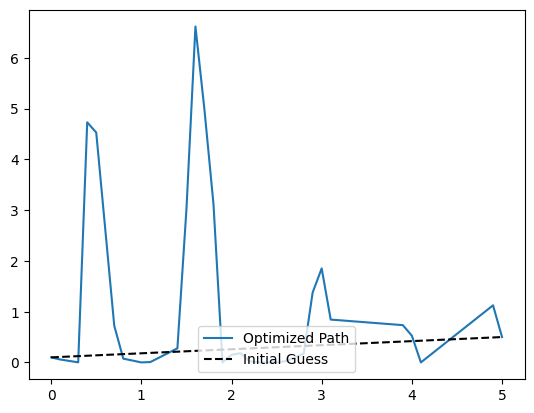

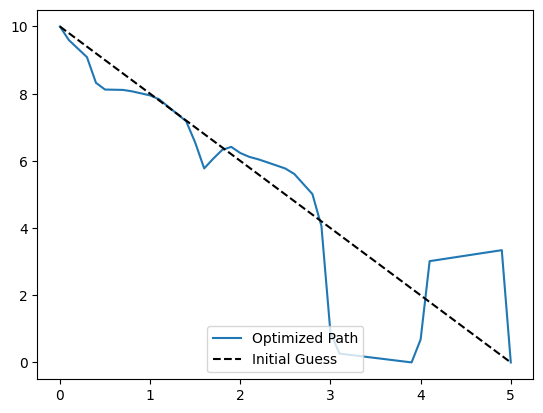

In [70]:
fig, ax = plt.subplots()
ax.plot(times_dense, J_V_path, label = "Optimized Path")
ax.plot(T * np.linspace(0, 1, num_control_points), np.linspace(J_V_init, J_V_final, num_control_points), '--k', label = "Initial Guess")
ax.legend(loc = "lower center")

fig, ax = plt.subplots()
ax.plot(times_dense, mu_V_path, label = "Optimized Path")
ax.plot(T * np.linspace(0, 1, num_control_points), np.linspace(mu_V_init, mu_V_final, num_control_points), '--k', label = "Initial Guess")
ax.legend(loc = "lower center")

(-10.0, 10.0)

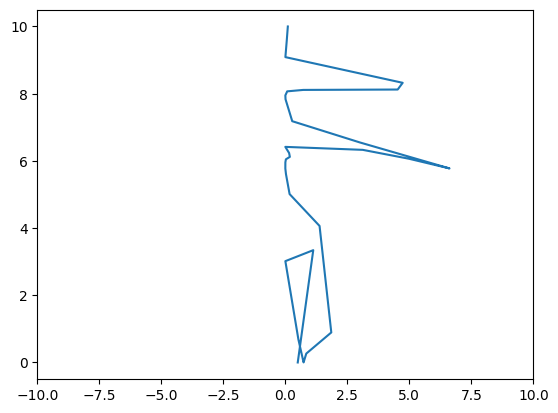

In [71]:
fig, ax = plt.subplots()
ax.plot(J_V_path, mu_V_path)
ax.set_xlim(-10,10)

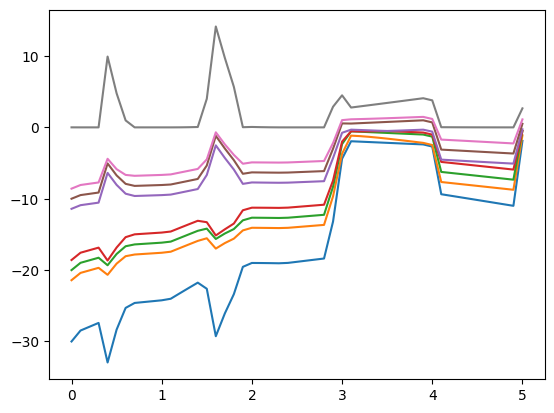

In [67]:
fig, ax = plt.subplots()
ax.plot(times_dense, true_energies)